In [1]:
import numpy as np
from TMDP import TMDP
from River_swim import River

#from algorithms import *
from PG_algorithms import *
from model_functions import *
import gym
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F

#np.set_printoptions(precision=4)
import math
from utils import *
from ActorCritic import *
from ReplayBuffer import ReplayBuffer

nS = 15
nA = 2
seed = get_current_seed()
seed = 44697628841978080856580175700798794719
gamma = .9
mu = np.ones(nS) * 1/nS
river = River(nS, mu, small=5, large=1000, seed=seed)
tau = 1.
xi = np.ones(nS) * 1/nS
tmdp = TMDP(river, xi, tau=tau, gamma=gamma, seed=seed)
mdp = TMDP(river, xi, tau=0., gamma=gamma, seed=seed)
tmdp_1 = TMDP(river, xi, tau=.5, gamma=gamma, seed=seed)


Current seed for result reproducibility: 113438644349549955100377896505847818127


In [2]:
rep_buffer = ReplayBuffer(max_size=int(10e6), input_shape=(1,), seed=seed)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ref_policy = ActorNet(nS, nA, hidden_dim=64).to(device)
policy_pi = ActorNet(nS, nA, hidden_dim=64).to(device)

q1_func = QNet(nS, nA, hidden_dim=64).to(device)
q2_func = QNet(nS, nA, hidden_dim=64).to(device)
q1_target = QNet(nS, nA, hidden_dim=64).to(device)
q2_target = QNet(nS, nA, hidden_dim=64).to(device)

In [4]:
ref_opt = torch.optim.Adam(ref_policy.parameters(), lr=1e-3)
q1_opt = torch.optim.Adam(q1_func.parameters(), lr=1e-2)
q2_opt = torch.optim.Adam(q2_func.parameters(), lr=1e-2)


In [5]:

tmdp.update_tau(.9)
tmdp.reset()
cur_res = curriculum_SAC(tmdp, policy_pi, ref_policy, q1_target, q2_target, q1_func,
                           q2_func, ref_opt, q1_opt, q2_opt, rep_buffer, 
                           alpha=.02, alpha_u=.02, beta=0.05, episodes=250000, 
                           batch_size=256, traj_steps=10, update_steps=1,
                           biased=False, last=True)

Q1 Loss:  7813.7548828125
Q2 Loss:  7814.7353515625
Actor Loss:  0.148780956864357
[(0.0, 0.89965)]
Alpha*: 0.0 tau*: 0.89965 Episode: 3416 length: 256 #teleports:3063
Got not null reward 2090.0!
Time for bound evaluation:  0.04100918769836426
Q1 Loss:  7808.91015625
Q2 Loss:  7809.31494140625
Actor Loss:  -0.018899869173765182
[(0.0, 0.8993)]
Alpha*: 0.0 tau*: 0.8993 Episode: 3417 length: 256 #teleports:1
Time for bound evaluation:  0.02200460433959961
Q1 Loss:  7804.24560546875
Q2 Loss:  7804.1474609375
Actor Loss:  -0.1476844698190689
[(0.00018, 0.8993), (0.0, 0.89895)]
Alpha*: 0.0 tau*: 0.89895 Episode: 3418 length: 256 #teleports:1
Time for bound evaluation:  0.024005651473999023
Q1 Loss:  7799.677734375
Q2 Loss:  7798.548828125
Actor Loss:  -0.21934697031974792
[(0.00042, 0.89895), (0.0, 0.8986)]
Alpha*: 0.0 tau*: 0.8986 Episode: 3419 length: 256 #teleports:1
Time for bound evaluation:  0.018004655838012695
Q1 Loss:  7794.8876953125
Q2 Loss:  7792.5400390625
Actor Loss:  -0.27739

In [6]:
print(ref_policy.get_probabilities())
print(q1_func.get_values())

[[0.93114448 0.06885549]
 [0.83420891 0.16579105]
 [0.81111318 0.18888684]
 [0.87986284 0.12013718]
 [0.40246254 0.59753746]
 [0.55347556 0.44652444]
 [0.8807807  0.11921935]
 [0.85003906 0.14996095]
 [0.52172446 0.47827557]
 [0.66303337 0.33696663]
 [0.52590132 0.47409871]
 [0.3429572  0.6570428 ]
 [0.38079664 0.61920339]
 [0.1326565  0.86734349]
 [0.8494854  0.15051462]]
[[  4.90643597   6.733284  ]
 [  4.3718152    4.87717819]
 [  3.78246403   3.23088956]
 [  3.17525554   3.03338909]
 [  2.73213291   2.14442539]
 [  2.25556207   1.84326124]
 [  1.62607348   2.29424739]
 [  1.38184226   1.46014738]
 [  1.09276044   1.10849977]
 [  0.21332936   0.89545822]
 [  0.57401496   1.55049956]
 [  1.39662182   6.96892071]
 [  3.63785505  19.83553696]
 [ 11.4606638   37.76683426]
 [ 38.33018494 195.59385681]]


In [7]:
res = bellman_optimal_q(tmdp.env.P_mat, tmdp.env.reward, tmdp.gamma)
Q = res["Q"]

d = compute_d_from_tau(tmdp.env.mu, tmdp.env.P_mat, tmdp.xi, get_policy(Q), tmdp.gamma, 0.)
d_curr = compute_d_from_tau(tmdp.env.mu, tmdp.P_mat_tau, tmdp.xi, get_policy(ref_policy.get_probabilities()), tmdp.gamma, 0.)

print(get_policy(Q))
print(get_policy(ref_policy.get_probabilities()))

r_s_a = compute_r_s_a(tmdp.env.P_mat, tmdp.env.reward)

j_opt = compute_j(r_s_a, get_policy(Q), d, tmdp.gamma)
j_curr = compute_j(r_s_a, get_policy(ref_policy.get_probabilities()), d_curr, tmdp.gamma)
print("optimal performance: ",j_opt, "curriculum performance: ",j_curr)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]
optimal performance:  213.31146154464213 curriculum performance:  16.901906876221886


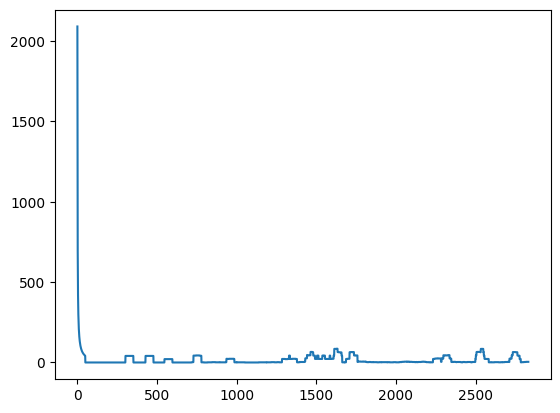

In [8]:
import matplotlib.pyplot as plt
reward_records = cur_res["reward_records"]
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
# Plot
#plt.plot(reward_records)
plt.plot(average_reward)
